In [ ]:
! pip install category_encoders
! pip install dtreeviz
! pip install imblearn

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from imblearn.over_sampling import SMOTE
from category_encoders import *
from sklearn.preprocessing import *
from imblearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import *
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.naive_bayes import BernoulliNB, GaussianNB
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import *

import graphviz
import graphviz.backend
from dtreeviz.trees import *

import warnings
warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", FutureWarning)

### Table of Contents

* [Background](#Background)
    * [Load in data](#Load_in_data)
        * [Encode target](#Encode_target)
        * [Missing values](#Missing_values)   
        * [Imbalanced data](#Imbalanced_data)
    * [Split data](#Split_data)
    * [Metrics](#Metrics)
    * [Choose algorithms](#Choose_algorithms)
        
* [Logistic Regression](#LogisticRegression)
    * [SMOTE](#lr_smote)
    * [Column transformations](#lr_encoding)
        * [Categorical](#lr_categorical)
        * [Numeric](#lr_continuous) 
        * [Combined](#lr_combined_encoders) 
    * [Tune hyperparameters](#lr_hyperparameters)

* [Random Forest](#RandomForest)
    * [SMOTE](#rf_smote)
    * [Column transformations](#rf_encoding)
        * [Categorical](#rf_categorical)
        * [Numeric](#rf_continuous) 
        * [Combined](#rf_combined_encoders) 
    * [Tune hyperparameters](#rf_hyperparameters)

* [Final Model](#Final_model)
    * [Visualization](#Visualization)
    * [Conclusion](#Conclusion)
    * [Future directions](#Future_directions)

### Background <a class="anchor" id="Background"></a>
The data used here comes from the UCI Machine Learning Repository; it is the "Drug consumption (quantified)" dataset. The dataset can be found at this url.

The data itself was collected via online survery from 1885 participants. The data collected includes demographic information, such as age, gender, education, country of residence, and ethnicity, personality inventory scores on traits such as neuroticism, extraversion, openness to experience, agreeableness, conscientiousness, impulsivity, and sensation seeking. In addition to these attributes, level of consumption of 18 drugs such as alcohol, amphetamines, amyl nitrite, benzodiazepine, cannabis, chocolate, cocaine, caffeine, crack, ecstasy, heroin, ketamine, legal highs, LSD, methadone, mushrooms, nicotine and volatile substance abuse were collected. To disqualify any potential participants who wanted to over-report use of drugs, participants also reported their consumption of a fake drug called "Semeron".

Participants were given 7 levels of consumption to choose from for each drug, "Never Used", "Used over a Decade Ago", "Used in Last Decade", "Used in Last Year", "Used in Last Month", "Used in Last Week", and "Used in Last Day".

In this notebook, I've decided to try to predict the level of participants' use of cannabis based on the collected demographic and personality inventory scores using machine learning. Here, I try two different machine learning algorithms to predict level of cannabis use: a logistic regression classifier model and a random forest classifier model.

** Note that the original data on the UCI website has been transformed from categorical values to a scaled numeric value, I simply converted the scaled numeric values back to their original categorical values and use the converted data in this notebook.

### Load in data <a class="anchor" id="Load_in_data"></a>

In [2]:
url = 'https://raw.githubusercontent.com/audreybarszcz/drug_consumption_machine_learning/main/drug_consumption.csv'
data = pd.read_csv(url)
data.head()

,ID,Age,Gender,Education,Country,Ethnicity,Nscore,Escore,Oscore,Ascore,...,Ecstasy,Heroin,Ketamine,Legal Highs,LSD,Methadone,Mushrooms,Nicotine,Semeron,Volatile Substance Abuse
0,1,35-44,Female,Professional certificate/ diploma,UK,Mixed-White/Asian,39.0,36.0,42.0,37.0,...,Never Used,Never Used,Never Used,Never Used,Never Used,Never Used,Never Used,Used in Last Decade,Never Used,Never Used
1,2,25-34,Male,Doctorate degree,UK,White,29.0,52.0,55.0,48.0,...,Used in Last Month,Never Used,Used in Last Decade,Never Used,Used in Last Decade,Used in Last Year,Never Used,Used in Last Month,Never Used,Never Used
2,3,35-44,Male,Professional certificate/ diploma,UK,White,31.0,45.0,40.0,32.0,...,Never Used,Never Used,Never Used,Never Used,Never Used,Never Used,Used over a Decade Ago,Never Used,Never Used,Never Used
3,4,18-24,Female,Masters degree,UK,White,34.0,34.0,46.0,47.0,...,Never Used,Never Used,Used in Last Decade,Never Used,Never Used,Never Used,Never Used,Used in Last Decade,Never Used,Never Used
4,5,35-44,Female,Doctorate degree,UK,White,43.0,28.0,43.0,41.0,...,Used over a Decade Ago,Never Used,Never Used,Used over a Decade Ago,Never Used,Never Used,Used in Last Decade,Used in Last Decade,Never Used,Never Used


In [3]:
X = data.iloc[:, 1:13] # feature columns, ignoring ID column
y = data.iloc[:, 18]   # cannabis use column

#### Encode target <a class="anchor" id="Encode_target"></a>

In [4]:
# transform y from string categories to numeric values
le = LabelEncoder().fit(y)
y = le.transform(y)

#### Missing values <a class="anchor" id="Missing_values"></a>

In [5]:
# luckily we have no missing values to impute!
data.isna().sum().sum()

0

#### Imbalanced data <a class="anchor" id="Imbalanced_data"></a>
Looking at the distribution of class labels y, there may be some class imbalance. For example, the class 0 (Never Used) and class 6 (Used in the last day) labels occur 2-3 times more often than classes 4 (Used in last month) or 5 (Used in last week). In an effort to make our predictions better, try adding SMOTE to our pipeline.

In [6]:
# relative proportion of each label
data.groupby('Cannabis').count()['Age']/data.groupby('Cannabis').count()['Age'].sum()

Cannabis
Never Used                0.219098
Used in Last Day          0.245623
Used in Last Decade       0.141114
Used in Last Month        0.074271
Used in Last Week         0.098143
Used in Last Year         0.111936
Used over a Decade Ago    0.109814
Name: Age, dtype: float64

### Split data <a class="anchor" id="Split_data"></a>
I chose 0.15 to use as the test data, leaving 0.85 remaining to split into training and validation sets. I again used a split of 0.15 for validation, 12.75% of the original data, and 0.85 for training, 72.25% of the original data. I wanted to split the data such that I would have about 75% of the data to train on. Additionally, I made sure to stratify my train-test-splits on y so each subset of the data would have the same relative distribution of labels in y.

In [7]:
# split off test data and never use until the end!!!
X_train, X_test, y_train, y_test = train_test_split(X, y.ravel(), test_size=0.15, stratify=y)

In [8]:
# split training set again into training and validation set
X_train_train, X_val, y_train_train, y_val = train_test_split(X_train, y_train, test_size=0.15, stratify=y_train)

### Metrics <a class="anchor" id="Metrics"></a>
For evaluating performance of each model, I am looking at both balanced accuracy score and the F1-weighted score. I feel that the F1-weighted score is a more accurate measure of performance of my model since it takes into account the class weights in addition to considering both precision and recall. Whereas, the balanced accuracy score simply averages the recall scores of each class, weighting each class equally. Therefore, I use F1-weighted as my scoring metric in the RandomizedSearchCV. 

In [9]:
#### FUNCTIONS ####

# helpful for trying different algorithms
class DummyEstimator(BaseEstimator):
    def fit(self): pass
    def score(self): pass
    

# helpful for trying different encoders/scalers
class DummyTransformer(TransformerMixin):
    def fit(self): pass
    def transform(self): pass
    
    
def fit_and_predict_random(grid, iterations):
    # search for best tranformer/algorithm
    # print out its scores and parameters
    rand = RandomizedSearchCV(estimator=pipe, 
                              param_distributions=grid, 
                              n_iter=iterations,
                              cv=5, 
                              scoring='f1_weighted',
                              n_jobs=-1,
                              verbose=1)

    best_model = rand.fit(X_train_train, y_train_train)
    y_pred = rand.predict(X_val)
    print('Balanced Accuracy:', balanced_accuracy_score(y_val, y_pred))
    print('F1 weighted:', f1_score(y_val, y_pred, average='weighted'))
    print(best_model.best_estimator_.get_params()['random'])
    pass


def fit_predict_pipe(X_train, y_train, X_test, y_test, pipe):
    # fit the pipe, get predictions and print out metrics
    model = pipe.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print('Balanced Accuracy:', balanced_accuracy_score(y_test, y_pred))
    print('F1 weighted:', f1_score(y_test, y_pred, average='weighted'))
    pass


def best_random_column(algorithm, grid, iterations, column):
    # try different transformers for different columns, using respective model
    pipe = Pipeline([('random', DummyTransformer()), 
                     ('model', algorithm)])

    rand = RandomizedSearchCV(estimator=pipe, 
                              param_distributions=grid, 
                              n_iter=iterations,
                              cv=5, 
                              scoring='f1_weighted',
                              n_jobs=-1,
                              verbose=1)
    
    if X_train_train.iloc[:, column].dtype == 'float64':
        best_model = rand.fit(X_train_train.iloc[:, column].values \
                              .reshape(-1, 1), y_train_train)
        
    else:
        best_model = rand.fit(X_train_train.iloc[:, column], y_train_train)
    print(best_model.best_estimator_.get_params()['random'])
    pass


def best_random_column_tuning(algorithm, transformer, grid, iterations, column):
    # try different transformer hyperparameters for different columns, using respective model
    pipe = Pipeline([('random', transformer), 
                     ('model', algorithm)])

    rand = RandomizedSearchCV(estimator=pipe, 
                              param_distributions=grid, 
                              n_iter=iterations,
                              cv=5, 
                              scoring='f1_weighted',
                              n_jobs=-1,
                              verbose=1)
    
    if X_train_train.iloc[:, column].dtype == 'float64':
        best_model = rand.fit(X_train_train.iloc[:, column].values \
                              .reshape(-1, 1), y_train_train)
        
    else:
        best_model = rand.fit(X_train_train.iloc[:, column], y_train_train)
    print(best_model.best_estimator_.get_params()['random'])
    pass

### Choose algorithms <a class="anchor" id="Choose_algorithms"></a>
I wanted to try two different models from sklearn, one from outside the ensemble module and one from the ensemble module.

In [10]:
# not including algorithms from sklearn.ensemble module
algorithms = [{'random': [BernoulliNB()]},
              {'random': [DecisionTreeClassifier()]},
              {'random': [ExtraTreeClassifier()]},
              {'random': [GaussianNB()]},
              {'random': [LogisticRegression(multi_class='multinomial', max_iter=1000)]},
              {'random': [RidgeClassifier()]}]

In [11]:
# basic bare minimum scaling/encoding
categorical_cols = (X.dtypes == 'object')

categorical_pipe = Pipeline([('ohe', OneHotEncoder())])

continuous_pipe = Pipeline([('scaler', StandardScaler())])

preprocessing = ColumnTransformer([('categorical', categorical_pipe,  categorical_cols),
                                   ('continuous',  continuous_pipe, ~categorical_cols)])

pipe = Pipeline([('preprocessing', preprocessing), 
                 ('random', DummyEstimator())])

In [12]:
# search for best basic algorithm from outside ensemble module
fit_and_predict_random(algorithms, 6)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Balanced Accuracy: 0.23184365625908918
F1 weighted: 0.27608467831554945
BernoulliNB()


In [13]:
# best model among ensemble module
algorithms = [{'random': [ExtraTreesClassifier()]},
              {'random': [RandomForestClassifier()]}]

In [14]:
# search for best basic algorithm from outside ensemble module
fit_and_predict_random(algorithms, 2)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
Balanced Accuracy: 0.25529220062836194
F1 weighted: 0.3081691040016332
RandomForestClassifier()


### LogisticRegression

#### SMOTE <a class="anchor" id="lr_smote"></a>

In [15]:
# baseline LogisticRegression performance without SMOTE
pipe = Pipeline([('preprocess', preprocessing),
                 ('lr', LogisticRegression(multi_class='multinomial', max_iter=1000))])

fit_predict_pipe(X_train_train, y_train_train, X_val, y_val, pipe)

Balanced Accuracy: 0.2711646470652472
F1 weighted: 0.31953202681856774


In [16]:
# try adding SMOTE to LogisticRegression
pipe = Pipeline([('preprocess', preprocessing),
                 ('random', SMOTE()), 
                 ('lr', LogisticRegression(multi_class='multinomial', max_iter=1000))])

In [17]:
# hyperparameter grid for SMOTE
strategy = ['minority', 'not minority', 'not majority', 'all', 'auto']
neighbors = [1, 3, 5, 7, 9]

smote_hyperparameters = [{'random': [SMOTE()],
                    'random__sampling_strategy': strategy,
                    'random__k_neighbors': neighbors}]

In [18]:
# adding SMOTE does not seem to help LogisticRegression
fit_and_predict_random(smote_hyperparameters, 25)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
Balanced Accuracy: 0.2556649602187516
F1 weighted: 0.2978784242435003
SMOTE(k_neighbors=3, sampling_strategy='not minority')


#### Column Transformations <a class="anchor" id="lr_encoding"></a>
As a baseline, I am just using one-hot encoding for all categorical columns and using StandardScaler for all numeric columns. Maybe different encodings could make the models better.

##### Categorical columns <a class="anchor" id="lr_categorical"></a>
For linear models, categorical variables should only be one hot encoded, so I am not going to try different categorical encoders on the data for the LogisticRegression model.

In [19]:
# columns 0-4 are categorical
categorical_cols

Age           True
Gender        True
Education     True
Country       True
Ethnicity     True
Nscore       False
Escore       False
Oscore       False
Ascore       False
Cscore       False
Impulsive    False
SS           False
dtype: bool

In [20]:
# baseline prediction for LogisticRegression only using categorical columns
pipe = Pipeline([('ohe', OneHotEncoder()), 
                 ('lr', LogisticRegression(max_iter=1000, multi_class='multinomial'))])

lr_cat_model = pipe.fit(X_train_train.iloc[:, :4], y_train_train)
y_pred = lr_cat_model.predict(X_val.iloc[:, :4])
print('Balanced Accuracy:', balanced_accuracy_score(y_val, y_pred))
print('F1 weighted:', f1_score(y_val, y_pred, average='weighted'))

Balanced Accuracy: 0.258249613589255
F1 weighted: 0.28662324534737427


##### Numeric columns <a class="anchor" id="lr_continuous"></a>

In [21]:
# columns 5-12 are numeric
~categorical_cols

Age          False
Gender       False
Education    False
Country      False
Ethnicity    False
Nscore        True
Escore        True
Oscore        True
Ascore        True
Cscore        True
Impulsive     True
SS            True
dtype: bool

In [22]:
# baseline prediction for LogisticRegression only using numeric columns
pipe = Pipeline([('scaler', StandardScaler()), 
                 ('lr', LogisticRegression(max_iter=1000, multi_class='multinomial'))])

lr_num_model = pipe.fit(X_train_train.iloc[:, 5:], y_train_train)
y_pred = lr_num_model.predict(X_val.iloc[:, 5:])
print('Balanced Accuracy:', balanced_accuracy_score(y_val, y_pred))
print('F1 weighted:', f1_score(y_val, y_pred, average='weighted'))

Balanced Accuracy: 0.23787666649646746
F1 weighted: 0.26446943777146875


In [23]:
# possible numeric scalers
num_encoders = [{'random': [StandardScaler()]}, 
                 {'random': [MinMaxScaler()]}, 
                 {'random': [MaxAbsScaler()]},  
                 {'random': [RobustScaler()]}, 
                 {'random': [QuantileTransformer()]}, 
                 {'random': [KBinsDiscretizer()]}]

In [24]:
# find best encoder for Nscore column
best_random_column(LogisticRegression(max_iter=1000, multi_class='multinomial'), num_encoders, 6, 5)
# find best encoder for Escore column
best_random_column(LogisticRegression(max_iter=1000, multi_class='multinomial'), num_encoders, 6, 6)
# find best encoder for Oscore column
best_random_column(LogisticRegression(max_iter=1000, multi_class='multinomial'), num_encoders, 6, 7)
# find best encoder for Ascore column
best_random_column(LogisticRegression(max_iter=1000, multi_class='multinomial'), num_encoders, 6, 8)
# find best encoder for Cscore column
best_random_column(LogisticRegression(max_iter=1000, multi_class='multinomial'), num_encoders, 6, 9)
# find best encoder for impulsive column
best_random_column(LogisticRegression(max_iter=1000, multi_class='multinomial'), num_encoders, 6, 10)
# find best encoder for SS column
best_random_column(LogisticRegression(max_iter=1000, multi_class='multinomial'), num_encoders, 6, 11)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
QuantileTransformer()
Fitting 5 folds for each of 6 candidates, totalling 30 fits
KBinsDiscretizer()
Fitting 5 folds for each of 6 candidates, totalling 30 fits
StandardScaler()
Fitting 5 folds for each of 6 candidates, totalling 30 fits
QuantileTransformer()
Fitting 5 folds for each of 6 candidates, totalling 30 fits
StandardScaler()
Fitting 5 folds for each of 6 candidates, totalling 30 fits
StandardScaler()
Fitting 5 folds for each of 6 candidates, totalling 30 fits
StandardScaler()


For columns that the best scaler is QuantileTransformer or KBinsDiscretizer, try tuning hyperparameters.

In [25]:
# hyperparameter grid for QuantileTransformer
nquantiles = [50, 100, 150, 200, 250]
dist = ['uniform', 'normal']

quant_hyperparams = [{'random': [QuantileTransformer()]}, 
                     {'random__n_quantiles': nquantiles}, 
                     {'random__output_distribution': dist}]

In [26]:
# hyperparameter grid for KBinsDiscretizer
nbins = [3, 5, 7, 9, 11]
encoding = ['one-hot', 'ordinal']
strategy = ['uniform', 'quantile', 'kmeans']

kbins_hyperparams = [{'random': [KBinsDiscretizer()]}, 
                     {'random__n_bins': nbins}, 
                     {'random__encode': encoding},
                     {'random__strategy': strategy}]

In [27]:
# find best KBinsDiscretizer hyperparameters for Nscore column, n_bins=3 is best
best_random_column_tuning(LogisticRegression(max_iter=1000, multi_class='multinomial'), KBinsDiscretizer(), kbins_hyperparams, 30, 5)

Fitting 5 folds for each of 11 candidates, totalling 55 fits
KBinsDiscretizer(n_bins=9)


In [28]:
# find best KBinsDiscretizer hyperparameters for Escore column, n_bins=7 is best
best_random_column_tuning(LogisticRegression(max_iter=1000, multi_class='multinomial'), KBinsDiscretizer(), kbins_hyperparams, 30, 6)

Fitting 5 folds for each of 11 candidates, totalling 55 fits
KBinsDiscretizer(n_bins=7)


In [29]:
# find best KBinsDiscretizer hyperparameters for Oscore column, n_bins=3 is best
best_random_column_tuning(LogisticRegression(max_iter=1000, multi_class='multinomial'), KBinsDiscretizer(), kbins_hyperparams, 30, 7)

Fitting 5 folds for each of 11 candidates, totalling 55 fits
KBinsDiscretizer(strategy='uniform')


In [30]:
# find best QuantileTransformer hyperparameters for Ascore column, default parameters are best
best_random_column_tuning(LogisticRegression(max_iter=1000, multi_class='multinomial'), QuantileTransformer(), quant_hyperparams, 10, 8)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
QuantileTransformer(output_distribution='normal')


In [31]:
# find best QuantileTransformer hyperparameters for impulsive column, default parameters are best
best_random_column_tuning(LogisticRegression(max_iter=1000, multi_class='multinomial'), QuantileTransformer(), quant_hyperparams, 10, 10)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
QuantileTransformer()


In [32]:
# using specific transformers for each column made the performace of the model better
quant_pipe = Pipeline([('qt', QuantileTransformer())])

kbins3_pipe = Pipeline([('kbins', KBinsDiscretizer(n_bins=3))])

kbins7_pipe = Pipeline([('kbins', KBinsDiscretizer(n_bins=7))])

stan_pipe = Pipeline([('ss', StandardScaler())])

numeric_preprocessing = ColumnTransformer([('quantile', quant_pipe,  ['Ascore', 'Impulsive']),
                                           ('k_bins3',  kbins3_pipe, ['Nscore', 'Oscore']), 
                                           ('k_bins7',  kbins7_pipe, ['Escore']), 
                                           ('standard',  stan_pipe, ['SS', 'Cscore'])])

pipe = Pipeline([('num_pipe', numeric_preprocessing), 
                 ('lr', LogisticRegression(max_iter=1000, multi_class='multinomial'))])

lr_num_model = pipe.fit(X_train_train.iloc[:, 5:], y_train_train)
y_pred = lr_num_model.predict(X_val.iloc[:, 5:])
print('Balanced Accuracy:', balanced_accuracy_score(y_val, y_pred))
print('F1 weighted:', f1_score(y_val, y_pred, average='weighted'))

Balanced Accuracy: 0.21736676762166332
F1 weighted: 0.24424201427466513


#### Put together categorical and continuous columns <a class="anchor" id="lr_combined_encoders"></a>

In [33]:
# baseline comparison, putting categorical and continuous columns together for predicting
preprocessing = ColumnTransformer([('categorical', categorical_pipe,  categorical_cols),
                                   ('continuous',  continuous_pipe, ~categorical_cols)])

pipe = Pipeline([('preprocessing', preprocessing), 
                 ('lr', LogisticRegression(max_iter=1000, multi_class='multinomial'))])

fit_predict_pipe(X_train_train, y_train_train, X_val, y_val, pipe)

Balanced Accuracy: 0.2711646470652472
F1 weighted: 0.31953202681856774


In [34]:
# using specific transformers for numeric columns heped the model
preprocessing = ColumnTransformer([('ohe',  OneHotEncoder(), categorical_cols), 
                                   ('quantile', quant_pipe,  ['Ascore', 'Impulsive']),
                                   ('k_bins3',  kbins3_pipe, ['Nscore', 'Oscore']), 
                                   ('k_bins7',  kbins7_pipe, ['Escore']), 
                                   ('standard',  stan_pipe, ['SS', 'Cscore'])])

pipe = Pipeline([('preprocessing', preprocessing), 
                 ('lr', LogisticRegression(max_iter=1000, multi_class='multinomial'))])

fit_predict_pipe(X_train_train, y_train_train, X_val, y_val, pipe)

Balanced Accuracy: 0.2694753253007735
F1 weighted: 0.32212545908694934


#### Search for best hyperparameters <a class="anchor" id="lr_hyperparameters"></a>

In [35]:
# before hyperparameter tuning
preprocessing = ColumnTransformer([('ohe',  OneHotEncoder(), categorical_cols), 
                                   ('quantile', quant_pipe,  ['Ascore', 'Impulsive']),
                                   ('k_bins3',  kbins3_pipe, ['Nscore', 'Oscore']), 
                                   ('k_bins7',  kbins7_pipe, ['Escore']), 
                                   ('standard',  stan_pipe, ['SS', 'Cscore'])])

pipe = Pipeline([('preprocessing', preprocessing), 
                 ('random', LogisticRegression(max_iter=1000, multi_class='multinomial'))])

fit_predict_pipe(X_train_train, y_train_train, X_val, y_val, pipe)

Balanced Accuracy: 0.2694753253007735
F1 weighted: 0.32212545908694934


In [36]:
# grid for LogisticRegression
penalty = ['l1', 'l2', 'none']
tol = [float(x) for x in np.logspace(-1, -7, 7)]
C = [float(x) for x in np.logspace(3, -3, 7)]
fit_intercept = [True, False]
class_weight = ['balanced', None]
solver = ['newton-cg', 'lbfgs', 'saga']    # liblinear does not support multinomial

hyperparameters = [{'random': [LogisticRegression(multi_class='multinomial', max_iter=1000)],
                    'random__penalty': penalty,
                    'random__tol': tol,
                    'random__C': C,
                    'random__fit_intercept': fit_intercept,
                    'random__class_weight': class_weight,
                    'random__solver': solver}]

In [37]:
# tuning hyperparameters hurt the model slightly
fit_and_predict_random(hyperparameters, 500)

Fitting 5 folds for each of 500 candidates, totalling 2500 fits
Balanced Accuracy: 0.2719406487841748
F1 weighted: 0.32170607771163784
LogisticRegression(C=10.0, max_iter=1000, multi_class='multinomial',
                   penalty='l1', solver='saga', tol=0.1)


Tuning the hyperparameters actually hurt the model performance on the validation set. The default hyperparameters provided by Sci-kit learn are better for predicting the data.

### RandomForest <a class="anchor" id="RandomForest"></a>

#### SMOTE <a class="anchor" id="rf_smote"></a>

In [38]:
# baseline RandomForest performance without SMOTE
preprocessing = ColumnTransformer([('categorical', categorical_pipe,  categorical_cols),
                                   ('continuous',  continuous_pipe, ~categorical_cols)])

pipe = Pipeline([('preprocess', preprocessing),
                 ('rf', RandomForestClassifier())])

fit_predict_pipe(X_train_train, y_train_train, X_val, y_val, pipe)

Balanced Accuracy: 0.2892979051954954
F1 weighted: 0.34473325180467373


In [39]:
# try adding SMOTE to RandomForest
pipe = Pipeline([('preprocess', preprocessing),
                 ('random', SMOTE()),
                 ('rf', RandomForestClassifier())])

In [40]:
# adding SMOTE seems to help RandomForest slightly, using k_neighbors=9
fit_and_predict_random(smote_hyperparameters, 25)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
Balanced Accuracy: 0.2592661001491115
F1 weighted: 0.31641440067931004
SMOTE(k_neighbors=9, sampling_strategy='minority')


#### Column Transformations <a class="anchor" id="rf_encoding"></a>

##### Categorical columns <a class="anchor" id="rf_categorical"></a>

In [41]:
# baseline prediction for RandomForest only using categorical columns
pipe = Pipeline([('ohe', OneHotEncoder()), 
                 ('smote', SMOTE(k_neighbors=9)),
                 ('rf', RandomForestClassifier())])

rf_cat_model = pipe.fit(X_train_train.iloc[:, :4], y_train_train)
y_pred = rf_cat_model.predict(X_val.iloc[:, :4])
print('Balanced Accuracy:', balanced_accuracy_score(y_val, y_pred))
print('F1 weighted:', f1_score(y_val, y_pred, average='weighted'))

Balanced Accuracy: 0.2503423038492359
F1 weighted: 0.29244279233905784


In [42]:
# possible category encoders
cat_encoders = [{'random': [CatBoostEncoder()]}, 
                {'random': [GLMMEncoder()]}, 
                {'random': [HashingEncoder()]},  
                {'random': [JamesSteinEncoder()]}, 
                {'random': [LeaveOneOutEncoder()]}, 
                {'random': [MEstimateEncoder()]}, 
                {'random': [OneHotEncoder()]}, 
                {'random': [OrdinalEncoder()]}, 
                {'random': [TargetEncoder()]}, 
                {'random': [WOEEncoder()]}]

In [43]:
# find best encoder for age column
best_random_column(RandomForestClassifier(), cat_encoders, 10, 0)
# find best encoder for education column
best_random_column(RandomForestClassifier(), cat_encoders, 10, 2)
# find best encoder for country column
best_random_column(RandomForestClassifier(), cat_encoders, 10, 3)
# find best encoder for ethnicity column
best_random_column(RandomForestClassifier(), cat_encoders, 10, 4)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
JamesSteinEncoder(cols=['Age'])
Fitting 5 folds for each of 10 candidates, totalling 50 fits
JamesSteinEncoder(cols=['Education'])
Fitting 5 folds for each of 10 candidates, totalling 50 fits
MEstimateEncoder(cols=['Country'])
Fitting 5 folds for each of 10 candidates, totalling 50 fits
TargetEncoder(cols=['Ethnicity'])


In [44]:
# using specific encoders for each column improved model performance
me_pipe = Pipeline([('me', MEstimateEncoder())])

te_pipe = Pipeline([('te', TargetEncoder())])

# since gender is binary in this dataset, doesn't need anything fancy
one_hot_pipe = Pipeline([('ohe', OneHotEncoder())])

categorical_pipe = ColumnTransformer([('me', me_pipe,  ['Age', 'Education']),
                                      ('te', te_pipe, ['Country', 'Ethnicity']),
                                      ('gender',  one_hot_pipe, ['Gender'])])

pipe = Pipeline([('cat_pipe', categorical_pipe), 
                 ('smote', SMOTE(k_neighbors=9)),
                 ('rf', RandomForestClassifier())])

fit_predict_pipe(X_train_train, y_train_train, X_val, y_val, pipe)

Balanced Accuracy: 0.24300636249459595
F1 weighted: 0.28128295980330936


##### Numeric columns <a class="anchor" id="rf_continuous"></a>

In [45]:
# baseline prediction performance before specifically encoding each column
pipe = Pipeline([('ss', StandardScaler()), 
                 ('smote', SMOTE(k_neighbors=9)),
                 ('rf', RandomForestClassifier())])

rf_cont_model = pipe.fit(X_train_train.iloc[:, 5:], y_train_train)
y_pred = rf_cont_model.predict(X_val.iloc[:, 5:])
print('Balanced Accuracy:', balanced_accuracy_score(y_val, y_pred))
print('F1 weighted:', f1_score(y_val, y_pred, average='weighted'))

Balanced Accuracy: 0.24570022701571453
F1 weighted: 0.28218880899309307


In [47]:
# find best encoder for Nscore column
best_random_column(RandomForestClassifier(), num_encoders, 6, 5)
# find best encoder for Escore column
best_random_column(RandomForestClassifier(), num_encoders, 6, 6)
# find best encoder for Oscore column
best_random_column(RandomForestClassifier(), num_encoders, 6, 7)
# find best encoder for Ascore column
best_random_column(RandomForestClassifier(), num_encoders, 6, 8)
# find best encoder for Cscore column
best_random_column(RandomForestClassifier(), num_encoders, 6, 9)
# find best encoder for impulsive column
best_random_column(RandomForestClassifier(), num_encoders, 6, 10)
# find best encoder for SS column
best_random_column(RandomForestClassifier(), num_encoders, 6, 11)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
MaxAbsScaler()
Fitting 5 folds for each of 6 candidates, totalling 30 fits
QuantileTransformer()
Fitting 5 folds for each of 6 candidates, totalling 30 fits
MaxAbsScaler()
Fitting 5 folds for each of 6 candidates, totalling 30 fits
MinMaxScaler()
Fitting 5 folds for each of 6 candidates, totalling 30 fits
StandardScaler()
Fitting 5 folds for each of 6 candidates, totalling 30 fits
MaxAbsScaler()
Fitting 5 folds for each of 6 candidates, totalling 30 fits
KBinsDiscretizer()


In [48]:
# find best KBinsDiscretizer hyperparameters for Oscore column, n_bins=3 is best
best_random_column_tuning(RandomForestClassifier(), KBinsDiscretizer(), kbins_hyperparams, 30, 7)

Fitting 5 folds for each of 11 candidates, totalling 55 fits
KBinsDiscretizer(strategy='uniform')


In [49]:
# find best KBinsDiscretizer hyperparameters for SS column, n_bins=9 is best
best_random_column_tuning(RandomForestClassifier(), KBinsDiscretizer(), kbins_hyperparams, 30, 11)

Fitting 5 folds for each of 11 candidates, totalling 55 fits
KBinsDiscretizer()


In [50]:
# using specific encoders for each column made the performace of the model better
max_abs_pipe = Pipeline([('mas', MaxAbsScaler())])

kbins9_pipe = Pipeline([('kbins', KBinsDiscretizer(n_bins=9))])

numeric_preprocessing = ColumnTransformer([('standard',  stan_pipe, ['Nscore', 'Escore', 'Impulsive']), 
                                           ('max_abs',  max_abs_pipe, ['Cscore']),  
                                           ('k_bins3',  kbins3_pipe, ['Oscore']), 
                                           ('k_bins9',  kbins9_pipe, ['SS'])])

pipe = Pipeline([('num_pipe', numeric_preprocessing), 
                 ('smote', SMOTE(k_neighbors=9)),
                 ('rf', RandomForestClassifier())])

etc_cont_model = pipe.fit(X_train_train.iloc[:, 5:], y_train_train)
y_pred = etc_cont_model.predict(X_val.iloc[:, 5:])
print('Balanced Accuracy:', balanced_accuracy_score(y_val, y_pred))
print('F1 weighted:', f1_score(y_val, y_pred, average='weighted'))

Balanced Accuracy: 0.22868862312089236
F1 weighted: 0.278278555697986


#### Combine categorical and continuous columns back together <a class="anchor" id="rf_combined_encoders"></a>

In [51]:
# baseline comparison, putting categorical and continuous columns together for predicting
preprocessing = ColumnTransformer([('categorical', categorical_pipe,  categorical_cols),
                                   ('continuous',  continuous_pipe, ~categorical_cols)])

pipe = Pipeline([('preprocessing', preprocessing), 
                 ('smote', SMOTE(k_neighbors=9)),
                 ('rf', RandomForestClassifier())])

fit_predict_pipe(X_train_train, y_train_train, X_val, y_val, pipe)

Balanced Accuracy: 0.2703708693686872
F1 weighted: 0.32149069310953954


In [52]:
# using specific transformers for columns helped the model
preprocessing = ColumnTransformer([('me', me_pipe,  ['Age', 'Education']),
                                   ('te', te_pipe, ['Country', 'Ethnicity']),
                                   ('gender',  one_hot_pipe, ['Gender']), 
                                   ('standard',  stan_pipe, ['Nscore', 'Escore', 'Impulsive']), 
                                   ('max_abs',  max_abs_pipe, ['Cscore']),  
                                   ('k_bins3',  kbins3_pipe, ['Oscore']), 
                                   ('k_bins9',  kbins9_pipe, ['SS'])])

pipe = Pipeline([('preprocessing', preprocessing),
                 ('smote', SMOTE(k_neighbors=9)),
                 ('rf', RandomForestClassifier())])

fit_predict_pipe(X_train_train, y_train_train, X_val, y_val, pipe)

Balanced Accuracy: 0.24250113866171358
F1 weighted: 0.2904623408016693


#### Search for best hyperparameters <a class="anchor" id="rf_hyperparameters"></a>

In [53]:
# before hyperparameter tuning
preprocessing = ColumnTransformer([('me', me_pipe,  ['Age', 'Education']),
                                   ('te', te_pipe, ['Country', 'Ethnicity']),
                                   ('gender',  one_hot_pipe, ['Gender']), 
                                   ('standard',  stan_pipe, ['Nscore', 'Escore', 'Impulsive']), 
                                   ('max_abs',  max_abs_pipe, ['Cscore']),  
                                   ('k_bins3',  kbins3_pipe, ['Oscore']), 
                                   ('k_bins9',  kbins9_pipe, ['SS'])])

pipe = Pipeline([('preprocessing', preprocessing), 
                 ('smote', SMOTE(k_neighbors=9)),
                 ('random', RandomForestClassifier())])

fit_predict_pipe(X_train_train, y_train_train, X_val, y_val, pipe)

Balanced Accuracy: 0.26909419356370956
F1 weighted: 0.3251991198009156


In [54]:
# grid for RandomForest
max_depth = [int(x) for x in np.linspace(25, 75, 3)]
max_depth.append(None)
min_samples_split = [int(x) for x in np.linspace(2, 10, 5)]
min_samples_leaf = [int(x) for x in np.linspace(1, 9, 5)]
max_features = ['auto', 'sqrt', 'log2', None]
bootstrap = [True, False]
class_weight = ['balanced', 'balanced_subsample', None]

hyperparameters = [{'random': [RandomForestClassifier()],
                    'random__max_depth': max_depth,
                    'random__min_samples_split': min_samples_split,
                    'random__min_samples_leaf': min_samples_leaf,
                    'random__max_features': max_features,
                    'random__bootstrap': bootstrap,
                    'random__class_weight' : class_weight}]

In [55]:
# tuning hyperparameters hurt the model
fit_and_predict_random(hyperparameters, 500)

Fitting 5 folds for each of 500 candidates, totalling 2500 fits
Balanced Accuracy: 0.2832588005559657
F1 weighted: 0.33891395815046205
RandomForestClassifier(class_weight='balanced_subsample', max_features='sqrt',
                       min_samples_split=6)


Again, tuning the hyperparameters hurt the model's performance on the validation set. The default values provided by Sci-kit learn are better for predicting the data.

### Final Model <a class="anchor" id="Final_model"></a>

For my final model, I am choosing the RandomForest model with tuned steps for preprocessing the columns along with incorporating SMOTE into my pipeline.

In [56]:
# see how my model performs on the test data!
preprocessing = ColumnTransformer([('me', me_pipe,  ['Age', 'Education']),
                                   ('te', te_pipe, ['Country', 'Ethnicity']),
                                   ('gender',  one_hot_pipe, ['Gender']), 
                                   ('standard',  stan_pipe, ['Nscore', 'Escore', 'Impulsive']), 
                                   ('max_abs',  max_abs_pipe, ['Cscore']),  
                                   ('k_bins3',  kbins3_pipe, ['Oscore']), 
                                   ('k_bins9',  kbins9_pipe, ['SS'])])

pipe = Pipeline([('preprocessing', preprocessing), 
                 ('smote', SMOTE(k_neighbors=9)),
                 ('random', RandomForestClassifier())])

fit_predict_pipe(X_train, y_train, X_test, y_test, pipe)

Balanced Accuracy: 0.2565596049078818
F1 weighted: 0.3154618227830758


Using my tuned and fully trained model, I am able to achieve a F1-weighted of 0.351 on the test data which is about ~0.03 better than my basic original model performed on the validation data. Including SMOTE in my pipeline and specifically encoding each feature of my data improved my ability to predict with a random forest model slightly.

In [57]:
# final parameters
print(pipe)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('me',
                                                  Pipeline(steps=[('me',
                                                                   MEstimateEncoder())]),
                                                  ['Age', 'Education']),
                                                 ('te',
                                                  Pipeline(steps=[('te',
                                                                   TargetEncoder())]),
                                                  ['Country', 'Ethnicity']),
                                                 ('gender',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder())]),
                                                  ['Gender']),
                                                 ('standard',
                                   

####  Visualization <a class="anchor" id="Visualization"></a>

Since we are unable to visualize an entire forest, I've shown a visualization for a simple tree in within the forest. 

In [58]:
ss = StandardScaler()
dtc = DecisionTreeClassifier(max_depth=4)

In [59]:
transform_n_a_ss_train = ss.fit_transform(X_train[['Nscore', 'Escore', 'Oscore', 'Ascore', 'Cscore', 'Impulsive', 'SS']])
transformed_n_train = transform_n_a_ss_train[:, 0]
transformed_e_train = transform_n_a_ss_train[:, 1]
transformed_o_train = transform_n_a_ss_train[:, 2]
transformed_a_train = transform_n_a_ss_train[:, 3]
transformed_c_train = transform_n_a_ss_train[:, 4]
transformed_impulsive_train = transform_n_a_ss_train[:, 5]
transformed_ss_train = transform_n_a_ss_train[:, 6]

In [60]:
transformed_train = pd.get_dummies(X_train.iloc[:, :4])
transformed_train['Nscore'] = transformed_n_train
transformed_train['Escore'] = transformed_e_train
transformed_train['Oscore'] = transformed_o_train
transformed_train['Ascore'] = transformed_a_train
transformed_train['Cscore'] = transformed_c_train
transformed_train['Impulsive'] = transformed_impulsive_train
transformed_train['SS'] = transformed_ss_train

In [61]:
dt_model = dtc.fit(transformed_train, y_train)

In [62]:
preprocessing = ColumnTransformer([('me', me_pipe,  ['Age', 'Education']),
                                   ('te', te_pipe, ['Country', 'Ethnicity']),
                                   ('gender',  one_hot_pipe, ['Gender']), 
                                   ('standard',  stan_pipe, ['Nscore', 'Escore', 'Impulsive']), 
                                   ('max_abs',  max_abs_pipe, ['Cscore']),  
                                   ('k_bins3',  kbins3_pipe, ['Oscore']), 
                                   ('k_bins9',  kbins9_pipe, ['SS'])])

pipe = Pipeline([('preprocessing', preprocessing), 
                 ('smote', SMOTE(k_neighbors=9)),
                 ('dtc', DecisionTreeClassifier())])

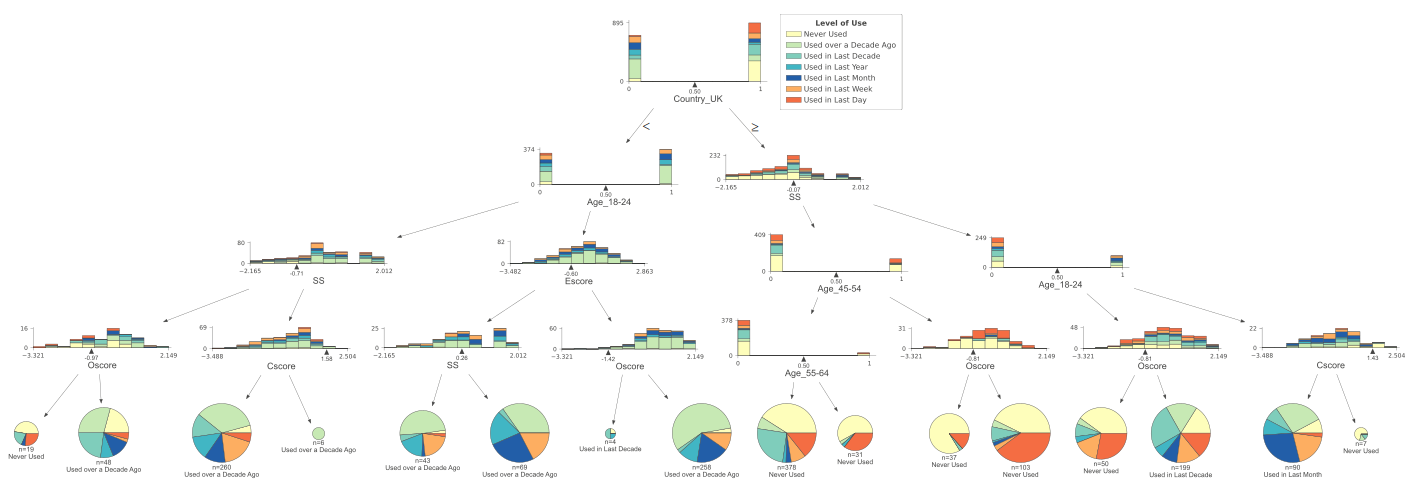

In [63]:
viz = dtreeviz(dtc, transformed_train, y_train,
               target_name='Level of Use', feature_names=transformed_train.columns.values,
               orientation='TD', class_names=["Never Used", "Used over a Decade Ago", 
                                              "Used in Last Decade", "Used in Last Year", 
                                              "Used in Last Month", "Used in Last Week", 
                                              "Used in Last Day"],
               fancy=True, label_fontsize=12, ticks_fontsize=8)
viz

Looking at the visualization of an example simple tree in the forest, we can see that the tree chooses the best feature, with the best value to split on that results in the purest subsequent nodes. A random forest takes many of these decision trees, in our case 100 of these trees, and asks each of them to give a prediction based on the given X. Each tree gives a prediction and the majority vote is the prediction from the forest.

### Conclusion <a class="anchor" id="Conclusion"></a>
In the end, a RandomForest model with the default hyperparameters performed the best on the validation set and yielded an F1-weighted score of 0.351 and a balanced accuracy score of 0.303. Before adding SMOTE to my pipeline, my F1-weighted score was 0.321 and my balanced accuracy score was 0.267. 

For the ideal SMOTE parameters, the RandomizedSearchCV chose the best k_neighbors value to be 9, which means it is looking at 9 points to create a polygon and is sampling points from within this shape.

Using RandomizedSearch CV to select the best categorical encoder, all categorical columns besides gender were transformed with some form of target encoder. For the numeric columns, the distributions of their values all seemed close to normal, so standard scaler worked for most of them.

Tuning the hyperparameters yielded worse a balanced accuracy score and a worse F1-weighted score than the default hyperparameters. I think this has to do with the overall difficulty of classifying the data. There are 7 labels the classifier is trying to predict and the reality of the distances between the labels aren't very far apart. For instance, is a cannabis user who last used cannabis a week ago versus a month ago that simple to differentiate? I think this is a very difficult prediction to make, which resulted in a lot of misclassifications. 

A better classification problem may be to predict whether someone has used a drug before or has never used a drug before. A model that could accurately predict between those two classes would be more useful in a business context as well.

#### Limitations
It's also important to point out the limitations of this data. Based on the demographic information collected in this dataset, a majority of the participants are between the ages of 18-34 years old, are white, are in either the UK or the USA, and have some college experience. Based on the demographic information, I would not try to use a model trained on this data to try and predict drug consumption for the general population. The demographics of this dataset are not well distributed and therefore, are probably not representative of the population as a whole. 

### Future Directions <a class="anchor" id="Future_directions"></a>
Along with trying a modified classification problem, future work could look into analyzing the features in the dataset to see if there is mulitcollinearity in the data and if so, remove some highly correlated features.

Assuming the simplified classification problem yielded better results, one could also look into the feature importances of the attributes provided in the dataset to, again, try and remove some weakly-predictive features and obtain a simpler, more accurate model.

A final idea I had was to create an overall personality column that classifies participants into certain personality labels based on their personality trait scores. For example, high impulsivity and high sensation seeking could correspond to an "addictive" personality and that attribute could be used to predict drug consumption, rather than using impulsivity and sensation seeking separately.